In [1]:
# Partially based on 
# https://github.com/GunhoChoi/Kind-PyTorch-Tutorial/blob/master/07_Denoising_Autoencoder/Denoising_Autoencoder.ipynb

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

with np.load('denoising-challenge-01-data.npz') as fh:
    training_images_clean = fh['training_images_clean']
    validation_images_noisy = fh['validation_images_noisy']
    validation_images_clean = fh['validation_images_clean']
    test_images_noisy = fh['test_images_noisy']

# TRAINING DATA: CLEAN
# 1. INDEX: IMAGE SERIAL NUMBER (20000)
# 2. INDEX: COLOR CHANNEL (1)
# 3/4. INDEX: PIXEL VALUE (28 x 28)
print(training_images_clean.shape, training_images_clean.dtype)

# VALIDATION DATA: CLEAN + NOISY
print(validation_images_clean.shape, validation_images_clean.dtype)
print(validation_images_noisy.shape, validation_images_noisy.dtype)

# TEST DATA: NOISY
print(test_images_noisy.shape, test_images_noisy.dtype)

# TRAIN MODEL ON training_images_clean

# CHECK YOUR MODEL USING (validation_images_clean, validation_images_noisy)

# DENOISE IMAGES (test_images_clean) USING test_images_noisy


(20000, 1, 28, 28) float32
(2000, 1, 28, 28) float32
(2000, 1, 28, 28) float32
(2000, 1, 28, 28) float32


In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils
from torch.autograd import Variable


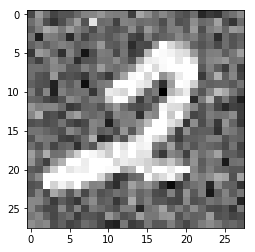

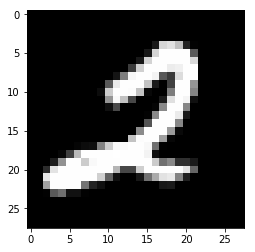

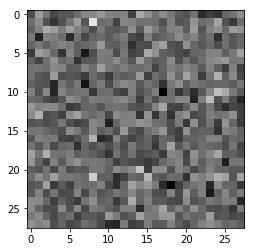

0.201801 0.0133218
0.204057 -0.00574335


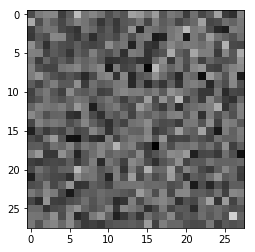

In [5]:
i = 1800
pic = validation_images_noisy[i][0]
plt.imshow(pic,cmap='gray',vmax=1)
plt.show()
pic = validation_images_clean[i][0]
plt.imshow(pic,cmap='gray',vmax=1)
plt.show()

noise = validation_images_noisy[i][0]-validation_images_clean[i][0]
plt.imshow(noise,cmap='gray',vmax=1)
plt.show()

noise = (validation_images_noisy[i][0]-validation_images_clean[i][0])
print(noise.std(),noise.mean())


artif_noise = (0.2*torch.Tensor.normal_(torch.zeros(28,28),std=1)).numpy()
print(artif_noise.std(),artif_noise.mean())
plt.imshow(artif_noise,cmap='gray',vmax=1)
plt.show()

In [6]:
#trans = transforms.ToTensor()
                            
batch_size = 128
train_dset = utils.TensorDataset(torch.from_numpy(training_images_clean)) # create your datset
train_loader = utils.DataLoader(train_dset, batch_size=batch_size, shuffle=True,num_workers=4) # create your dataloader

val_dset = utils.TensorDataset(torch.from_numpy(validation_images_clean),torch.from_numpy(validation_images_noisy))
val_loader = utils.DataLoader(val_dset,batch_size=2000, shuffle=False, num_workers=4)

test_dset = utils.TensorDataset(torch.from_numpy(test_images_noisy))
test_loader = utils.DataLoader(test_dset,batch_size=2000, shuffle=False, num_workers=4)

In [7]:
# Encoder 
# torch.nn.Conv2d(in_channels, out_channels, kernel_size,
#                 stride=1, padding=0, dilation=1,
#                 groups=1, bias=True)
# batch x 1 x 28 x 28 -> batch x 512

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(1,32,3,padding=1),   # batch x 16 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32,32,3,padding=1),   # batch x 16 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32,64,3,padding=1),  # batch x 32 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.Conv2d(64,64,3,padding=1),  # batch x 32 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.MaxPool2d(2,2)   # batch x 64 x 14 x 14
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(64,128,3,padding=1),  # batch x 64 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.Conv2d(128,128,3,padding=1),  # batch x 64 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.MaxPool2d(2,2),
                        nn.Conv2d(128,256,3,padding=1),  # batch x 64 x 7 x 7
                        nn.ReLU()
        )
        
                
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(x.size()[0], -1)
        return out
    
encoder = Encoder()

In [8]:
# Decoder 
# torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size,
#                          stride=1, padding=0, output_padding=0,
#                          groups=1, bias=True)
# output_height = (height-1)*stride + kernel_size - 2*padding + output_padding
# batch x 512 -> batch x 1 x 28 x 28

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.ConvTranspose2d(256,128,3,2,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.ConvTranspose2d(128,128,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.ConvTranspose2d(128,64,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.ConvTranspose2d(64,64,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(64)
        )
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(64,32,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.ConvTranspose2d(32,32,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.ConvTranspose2d(32,8,3,2,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(8),
                        nn.ConvTranspose2d(8,1,3,1,1),
        )
        
    def forward(self,x):
        out = x.view(x.size()[0],256,7,7)
        out = self.layer1(out)
        out = self.layer2(out)
        return out

decoder = Decoder()

In [9]:
# Check output of autoencoder

for image, in train_loader:
    
    image = Variable(image)
    
    output = encoder(image)
    print(output.size()[0])
    
    output = decoder(output)
    print(output.size())
    break

128
torch.Size([128, 1, 28, 28])


In [10]:
# loss func and optimizer
# we compute reconstruction after decoder so use Mean Squared Error
# In order to use multi parameters with one optimizer,
# concat parameters after changing into list
learning_rate = 0.0005
parameters = list(encoder.parameters())+ list(decoder.parameters())
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=learning_rate)

In [11]:
def evaluate():
    encoder.eval()
    decoder.eval()
    val_loss = 0
    i = 0
    with torch.no_grad():
        for image_c, image_n in val_loader:
            # if torch.cuda.is_available():
            #     data, target = data.cuda(), target.cuda()
            image_c, image_n = Variable(image_c), Variable(image_n)
            output = encoder(image_n)
            output = decoder(output)
            val_loss += loss_func(output, image_c).item()  # sum up batch loss
            i += 1
        #val_loss /= len(val_loader.dataset)
        print('\nValidation set: Average loss: {:.4f}'.format(
            val_loss / i))
    return val_loss / i

In [12]:
def predict():
    encoder.eval()
    decoder.eval()
    val_loss = 0
    with torch.no_grad():
        for image_n, in test_loader:
            # if torch.cuda.is_available():
            #     data = data.cuda(), target.cuda()
            image_n = Variable(image_n)
            output = encoder(image_n)
            output = decoder(output)
    return output

In [28]:
# train encoder and decoder
# save and load model
epochs = 10

try:
    encoder, decoder = torch.load('./model/deno_autoencoder-0_79.pkl')
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass

train_losses = []
val_losses = []
val_loss = evaluate() 
val_losses.append(val_loss)
for epoch in range(epochs):
    encoder.train()
    decoder.train()
    for batch_idx, (image,) in enumerate(train_loader):
        batchsize = image.size()[0]
        noise = torch.Tensor.normal_(torch.zeros(batchsize,1,28,28),std=1)
        image_n = Variable(torch.add(image, 0.2*noise))
        image = Variable(image)

        optimizer.zero_grad()
        output = encoder(image_n)
        output = decoder(output)
        loss = loss_func(output,image)
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss)
            
        if batch_idx % 1 == 0:
            print('\rTrain Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.8f}'.format(
                epoch, batch_idx * len(image), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss),end='')
        
    
    val_loss = evaluate() 
    val_losses.append(val_loss)
    if val_loss < val_losses[-2]:
        print("taking snapshot")
        torch.save([encoder,decoder],'./model/deno_autoencoder-0_79.pkl')


--------model restored--------


Validation set: Average loss: 0.0041
Train Epoch: 0 [4992/20000 (99%)]	Loss: 0.0042075
Validation set: Average loss: 0.0041
Train Epoch: 1 [4992/20000 (99%)]	Loss: 0.0039574
Validation set: Average loss: 0.0041
taking snapshot


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Decoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Train Epoch: 2 [4992/20000 (99%)]	Loss: 0.0048252
Validation set: Average loss: 0.0042
Train Epoch: 3 [4992/20000 (99%)]	Loss: 0.0038812
Validation set: Average loss: 0.0041
taking snapshot
Train Epoch: 4 [4992/20000 (99%)]	Loss: 0.0050439
Validation set: Average loss: 0.0042
Train Epoch: 5 [9472/20000 (47%)]	Loss: 0.004071

Process Process-135:
Process Process-134:
Process Process-136:
Process Process-133:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/multiprocessing/process.py", line 254, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/multiprocessing/process.py", line 254, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/multiprocessing/process.py", line 254, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/multiprocessing/process.py", line 254, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions

KeyboardInterrupt: 

In [13]:
loss_func = nn.MSELoss(size_average=False)
try:
    encoder, decoder = torch.load('./model/deno_autoencoder-0_79.pkl')
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass

loss = evaluate()


--------model restored--------


Validation set: Average loss: 6478.9824


In [16]:
def evaluate():
    '''Caluclating the loss in the abgabe'''
    encoder.eval()
    decoder.eval()
    val_loss = 0
    with torch.no_grad():
        for image_c, image_n in val_loader:
            # if torch.cuda.is_available():
            #     data, target = data.cuda(), target.cuda()
            image_c, image_n = Variable(image_c), Variable(image_n)
            output = encoder(image_n)
            output = decoder(output)
            abgabe_loss = (output-image_c).numpy()
            abgabe_loss = np.sqrt(np.square(abgabe_loss).reshape(2000,-1).sum(axis=1)).mean()
            val_loss += loss_func(output, image_c).item()  # sum up batch loss
            break
        print('\nValidation set: Average loss: {:.4f} | Frobnorm: {:.4f}'.format(
            val_loss,abgabe_loss))
    return val_loss

In [17]:
loss = evaluate()

1.7778

Validation set: Average loss: 6478.9824 | Frobnorm: 1.7778


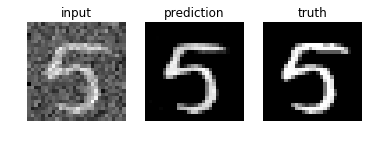

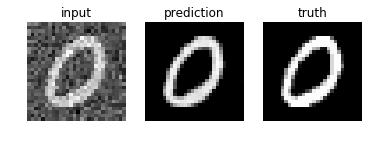

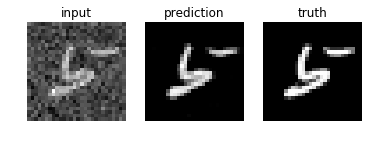

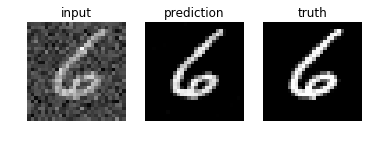

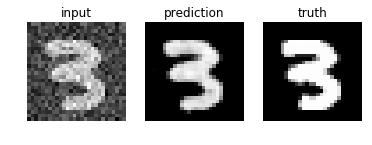

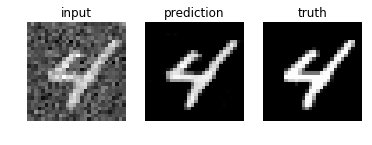

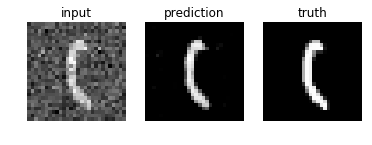

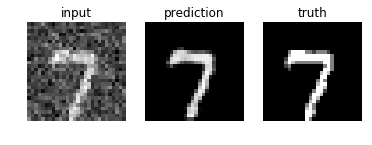

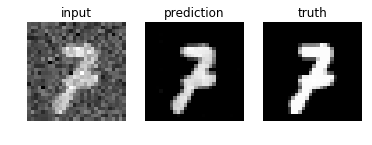

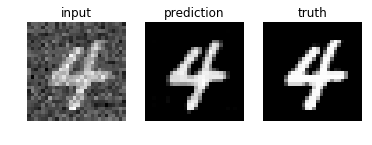

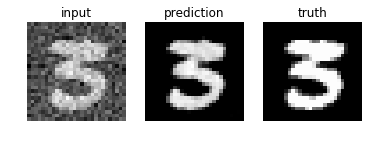

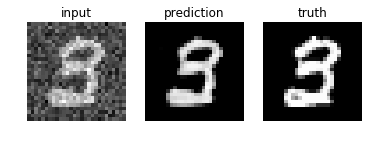

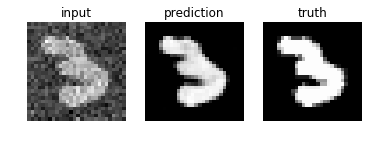

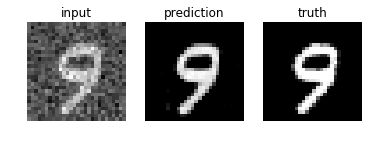

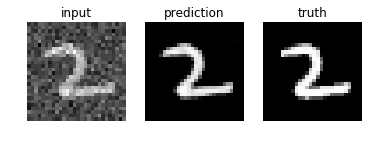

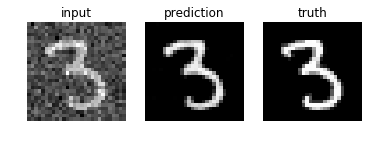

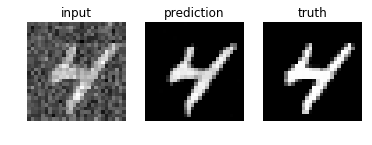

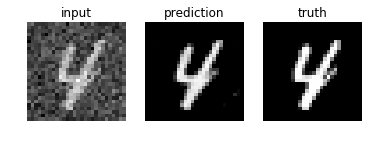

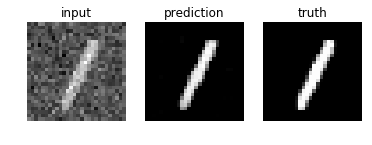

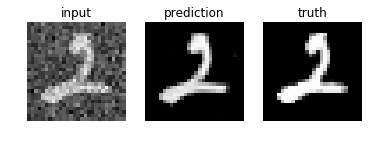

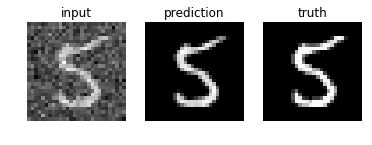

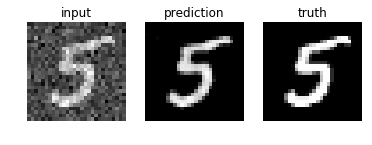

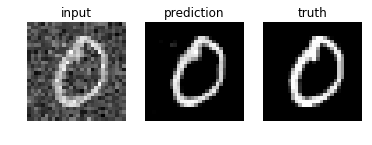

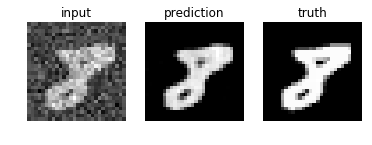

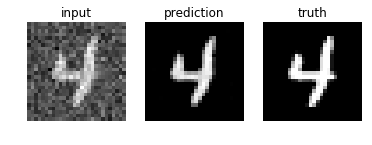

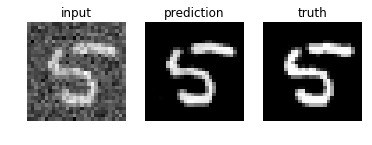

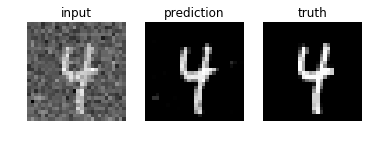

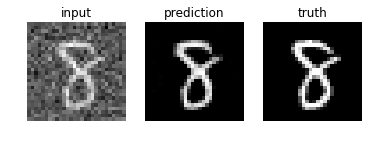

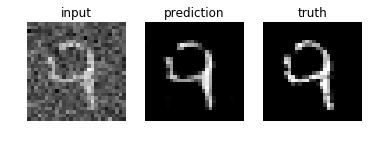

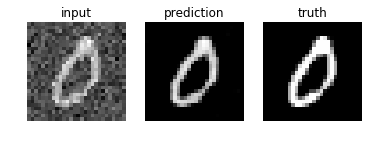

In [30]:
encoder.eval()
decoder.eval()
for batch_idx, (image,) in enumerate(train_loader):
        batchsize = image.size()[0]
        noise = torch.Tensor.normal_(torch.zeros(batchsize,1,28,28),std=1)#torch.rand(batch_size,1,28,28)
        image_n = torch.add(image, 0.2*noise)
        image = Variable(image)
        image_n = Variable(image_n)

        output = encoder(image_n)
        output = decoder(output)
        for i in range(min(image.numpy().shape[0],30)):
            fig, axes = plt.subplots(1,3)
            axes[2].imshow(image.numpy()[i][0],cmap='gray')
            axes[2].set_title('truth')
            axes[2].axis('off')
            axes[0].imshow(image_n.numpy()[i][0],cmap='gray')
            axes[0].set_title('input')
            axes[0].axis('off')
            axes[1].imshow(output.detach().numpy()[i][0],cmap='gray')
            axes[1].set_title('prediction')
            axes[1].axis('off')
            plt.show()
        break

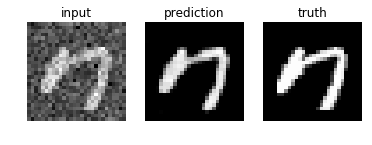

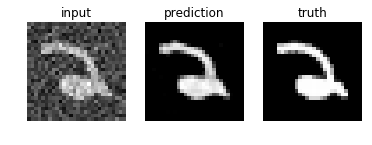

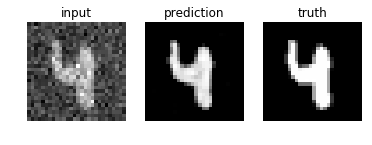

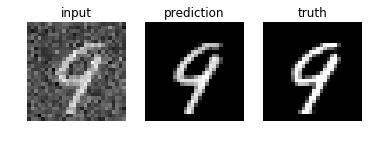

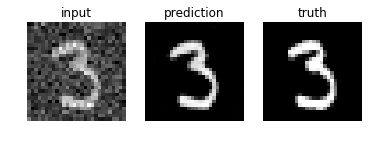

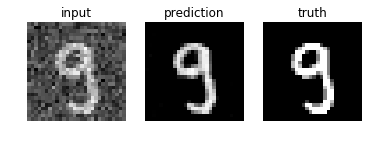

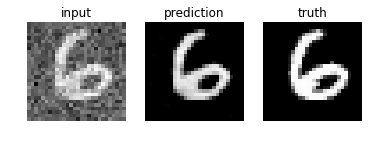

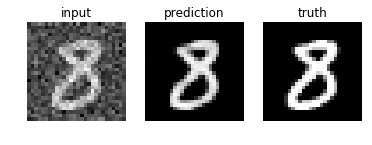

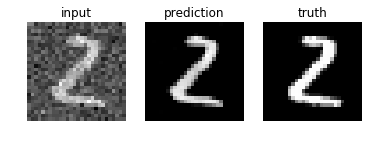

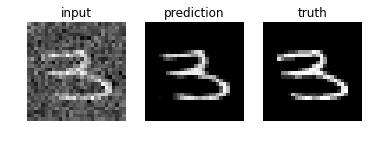

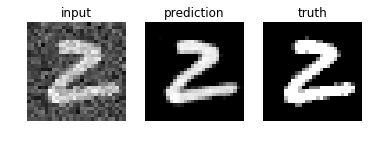

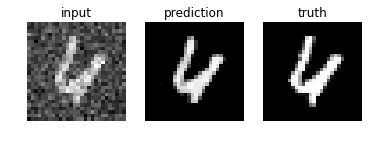

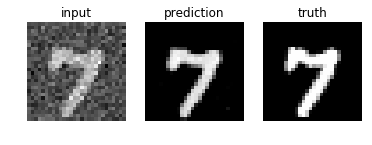

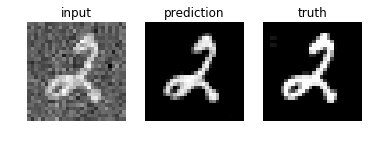

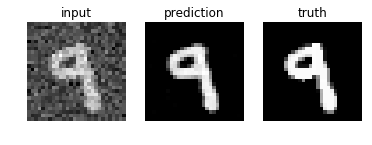

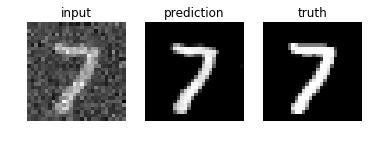

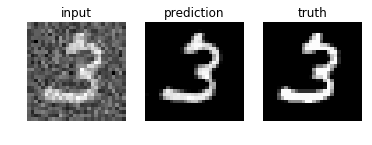

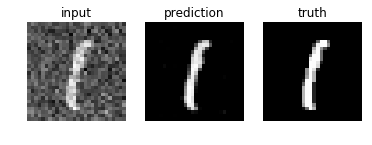

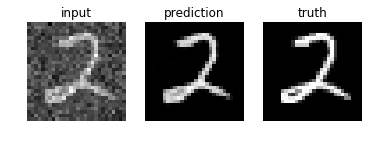

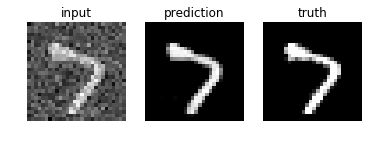

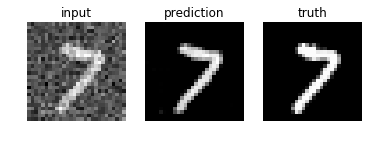

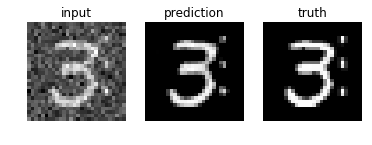

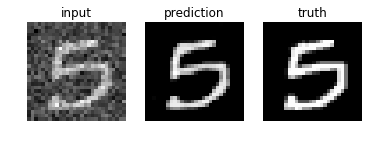

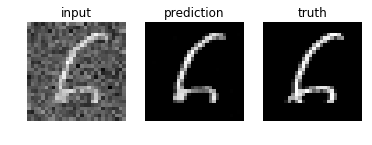

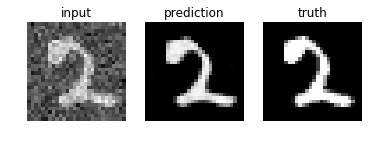

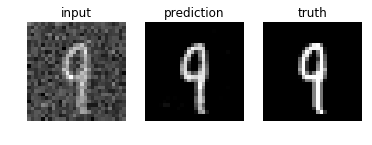

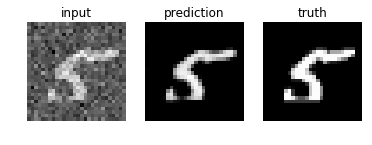

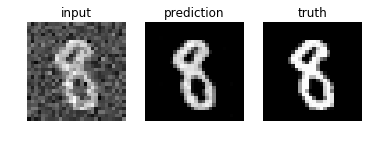

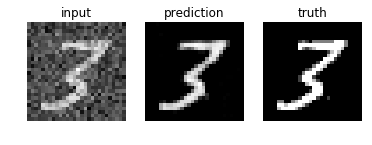

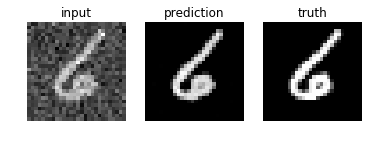

In [31]:
encoder.eval()
decoder.eval()
for image_c,image_n in val_loader:
    data, target = Variable(image_c), Variable(image_n)
    output = encoder(image_n)
    output = decoder(output)
    for i in range(min(image_c.numpy().shape[0],30)):
        fig, axes = plt.subplots(1,3)
        axes[2].imshow(image_c.numpy()[i][0],cmap='gray')
        axes[2].set_title('truth')
        axes[2].axis('off')
        axes[0].imshow(image_n.numpy()[i][0],cmap='gray')
        axes[0].set_title('input')
        axes[0].axis('off')
        axes[1].imshow(output.detach().numpy()[i][0],cmap='gray')
        axes[1].set_title('prediction')
        axes[1].axis('off')
        plt.show()
    
    break

In [32]:
pred = predict()

In [33]:
test_images_clean = pred.numpy()

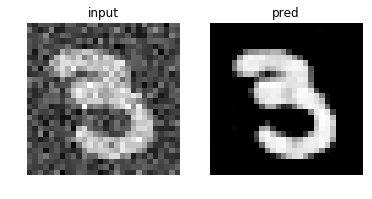

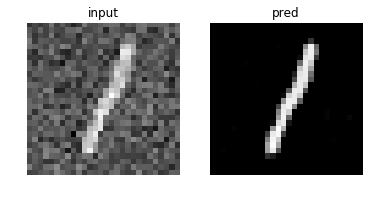

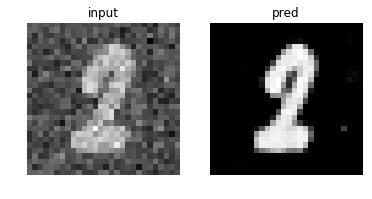

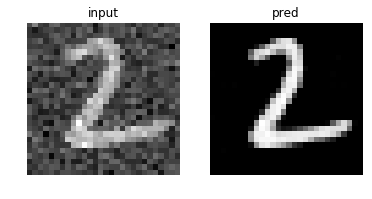

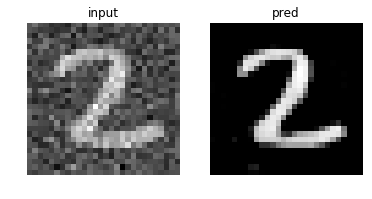

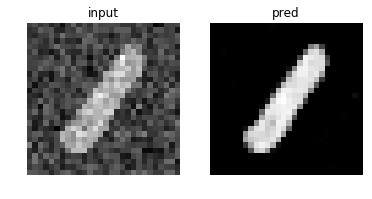

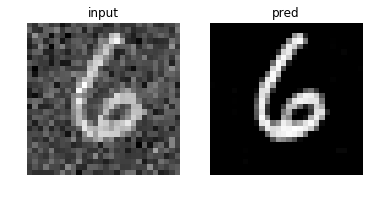

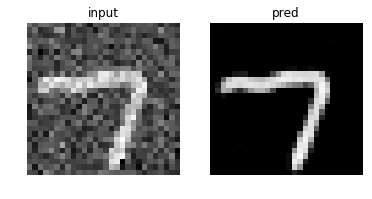

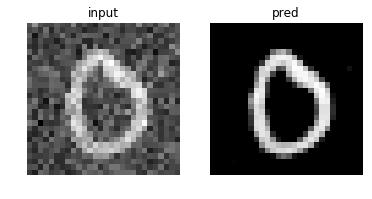

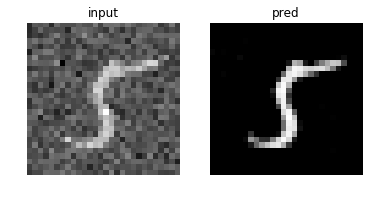

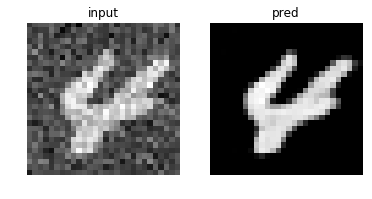

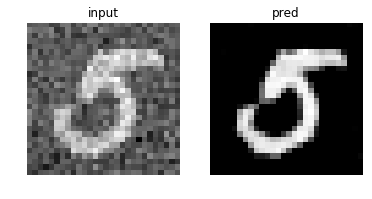

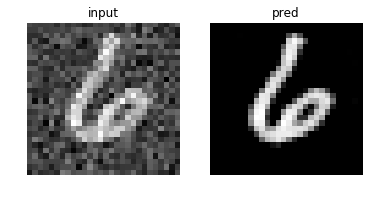

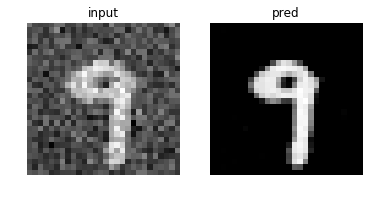

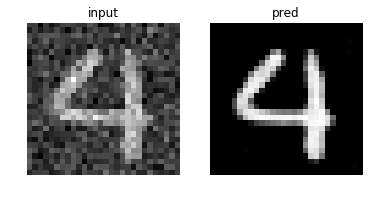

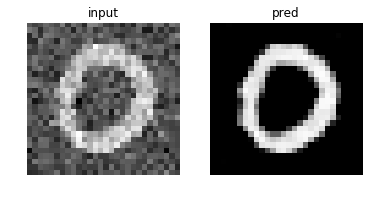

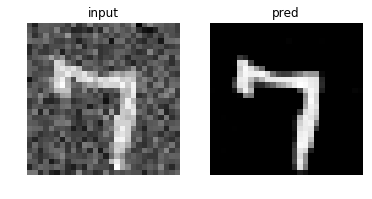

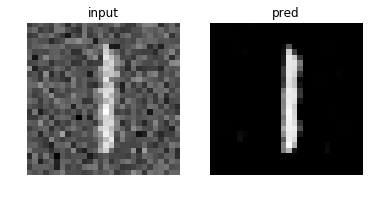

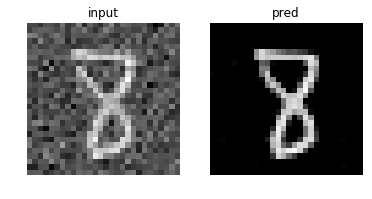

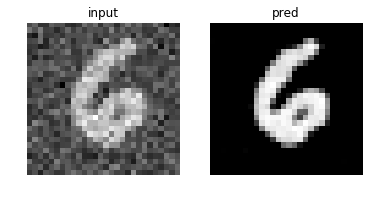

In [36]:
for i in range(20):
        fig, axes = plt.subplots(1,2)
        axes[1].imshow(test_images_clean[i*100][0],cmap='gray')
        axes[1].set_title('pred')
        axes[1].axis('off')
        axes[0].imshow(test_images_noisy[i*100][0],cmap='gray')
        axes[0].set_title('input')
        axes[0].axis('off')
        plt.show()

In [35]:

# MAKE SURE THAT YOU HAVE THE RIGHT FORMAT
assert test_images_clean.ndim == 4
assert test_images_clean.shape[0] == 2000
assert test_images_clean.shape[1] == 1
assert test_images_clean.shape[2] == 28
assert test_images_clean.shape[3] == 28

# AND SAVE EXACTLY AS SHOWN BELOW
np.save('test_images_clean3.npy', test_images_clean)